In [12]:
%matplotlib widget
%load_ext autoreload
import numpy as np
import os 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.figure, matplotlib.axes
import os
import sys
import numpy as np
import pickle as pkl
import yaml 
import tqdm
import collections.abc
import torch
from utils import PredictionResults
print(sys.version)
print(sys.version_info)

thisfiledir=os.path.abspath("")
deepracingmodelsdir = os.path.abspath(os.path.join(thisfiledir, ".."))
deepracingdir = os.path.abspath(os.path.join(thisfiledir, "..", "..", "deepracing_py"))
if (not (deepracingmodelsdir in sys.path)) or (not (deepracingdir in sys.path)):
    sys.path = [deepracingmodelsdir, deepracingdir] + sys.path

homedir = os.environ["HOME"]

mtrdir=os.path.join(homedir, "deepracingws", "MTR")
print(mtrdir)
if (not (mtrdir in sys.path)):
    sys.path.insert(0, mtrdir)
print(sys.path)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Yay
3.10.13 (main, Oct  5 2023, 13:37:03) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)
/l/ttw2xk/deepracingws/MTR
['/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch', '/l/ttw2xk/deepracingws/src/deepracing/deepracing_py', '/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting', '/p/DeepRacing/deepracingws/src/deepracing/DCNN-Pytorch', '/p/DeepRacing/deepracingws/src/deepracing/deepracing_py', '/sw/ubuntu-22.04/python/3.10.13/lib/python310.zip', '/sw/ubuntu-22.04/python/3.10.13/lib/python3.10', '/sw/ubuntu-22.04/python/3.10.13/lib/python3.10/lib-dynload', '', '/l/ttw2xk/python3venvs/deepracing310/lib/python3.10/site-packages', '/l/ttw2xk/deepracingws/MTR']


In [2]:

from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils
import torch.utils.data as torchdata
keys : set = {
    "hist",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_quats",
    "fut_vel",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "thistory",
    "tfuture"
}
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files("/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard",
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)


bezier_experiment = "widespread_beans_6059"
bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BezierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_experiment = "chosen_preservative_7505"
composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "BARTé")
composite_results.compute_fde()
composite_curves = torch.as_tensor(composite_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
composite_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_experiment = "agricultural_flue_8932"
mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()

mtr_experiment = "formal_pedestal_9890"
mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results", mtr_experiment)
mtr_data_dir = "/p/DeepRacing/unpacked_datasets/local_fitting/v1/mtr_format/1second"
mtr_scenarios_dir = os.path.join(mtr_data_dir, "processed_scenarios_test")
mtr_sortfile = os.path.join(mtr_results_dir, "test_plots", "idx_sort.npz")
if not os.path.isfile(mtr_sortfile):
    with open(os.path.join(mtr_data_dir, "processed_scenarios_test_infos.pkl"), "rb") as f:
        mtr_infos = pkl.load(f)
    mtr_keys = mtr_infos[0].keys()
    entries = []
    for (idx, info) in tqdm.tqdm(enumerate(mtr_infos), total=len(mtr_infos)):
        scenario_id = info["scenario_id"]
        with open(os.path.join(mtr_scenarios_dir, scenario_id+".metadata.yaml"), "r") as f:
            scenario_metadata = yaml.safe_load(f)
        deepracing_dir = os.path.dirname(scenario_metadata["deepracing_file"])
        dset_index = scenario_metadata["index"]
        car_index = int(os.path.basename(deepracing_dir).split("_")[-1])
        dated_trackname : str = os.path.basename(os.path.dirname(deepracing_dir))
        trackname = dated_trackname.split("_")[0]
        entries.append((idx, scenario_id, trackname, car_index, dset_index))
    entries_sorted = sorted(entries, key=lambda entry : (entry[2], entry[3], entry[4]))
    scenario_ids_sorted = np.asarray([e[1] for e in entries_sorted], dtype=object)
    idx_sort = np.asarray([e[0] for e in entries_sorted], dtype=np.int64)
    with open(mtr_sortfile, "wb") as f:
        np.savez(f, idx_sort=idx_sort, scenario_ids=scenario_ids_sorted)

with open(mtr_sortfile, "rb") as f:
    npfile = np.load(f, allow_pickle=True)
    sort_idx_mtr = npfile["idx_sort"].copy()
    scenario_ids_sorted = npfile["scenario_ids"].copy()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "test_plots", "data.npz"), "MTR", sort_idx=sort_idx_mtr)
mtr_results["predictions_all"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(mtr_results["predictions_all"][:,0])
for idx in range(mtr_results["predictions_all"].shape[0]):
    mtr_results["predictions"][idx] = mtr_results["predictions_all"][idx,mtr_results["best_curve_idx"][idx]]
mtr_results.compute_fde()
# for k in ["history", "ground_truth"]

all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, composite_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))



Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_0/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_1/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_2/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_3/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_4/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_5/metadata.yaml
Loading data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15

In [3]:
from torch.utils.data import Subset

nonoutliers = composite_results.trim_percentiles(metric="ade", whis=2.5)
outliers = ~nonoutliers
print(len(fulldset))
print(np.sum(nonoutliers))
print(np.sum(outliers))

composite_results_trimmed = composite_results.subsample(nonoutliers)
bezier_results_trimmed = bezier_results.subsample(nonoutliers)
mtr_results_trimmed = mtr_results.subsample(nonoutliers)
mixnet_results_trimmed = mixnet_results.subsample(nonoutliers)
fulldset_trimmed = Subset(fulldset, np.where(nonoutliers)[0])


barte_nonoutliers = composite_results.trim_percentiles(metric="ade")
mtr_nonoutliers = mtr_results.trim_percentiles(metric="ade")
# print(np.sum(mtr_nonoutliers*(~barte_nonoutliers)))
# print(np.sum(barte_nonoutliers*(~mtr_nonoutliers)))

126577
121251
5326


In [4]:


import shutil

rcparams_latex = {
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
}
def plot_error_histograms(results : PredictionResults, plotbase : str, bins=200, notch=True):
    savedir = os.path.join(plotbase, results.modelname)
    if os.path.isdir(savedir):
        shutil.rmtree(savedir)
    os.makedirs(savedir)
    for (key, title) in {("fde", "FDE"), ("ade", "MinADE"), ("lateral_error","Lateral Error"), ("longitudinal_error","Longitudinal Error")}:
        errors = results[key]
        modelname = results.modelname
        
        fig : matplotlib.figure.Figure = plt.figure()
        plt.hist(errors, bins=bins)
        plt.title(title + ": " + modelname)
        fig.savefig(os.path.join(savedir, "%s_%s_histogram.png" % (modelname, key)), backend="agg")
        fig.savefig(os.path.join(savedir, "%s_%s_histogram.pdf" % (modelname, key)), backend="pdf")
        fig.savefig(os.path.join(savedir, "%s_%s_histogram.pgf" % (modelname, key)), backend="pgf")
        plt.close(fig=fig)

        figbox : matplotlib.figure.Figure = plt.figure()
        plt.title(title + ": " + modelname)
        plt.boxplot(errors, notch=notch)
        figbox.savefig(os.path.join(savedir, "%s_%s_boxplot.png" % (modelname, key)), backend="agg")
        figbox.savefig(os.path.join(savedir, "%s_%s_boxplot.pdf" % (modelname, key)), backend="pdf")
        figbox.savefig(os.path.join(savedir, "%s_%s_boxplot.pgf" % (modelname, key)), backend="pgf")
        plt.close(fig=figbox)
        
def plot_outliers(results_list : list[PredictionResults], plotdir : str, fulldset : torchdata.ConcatDataset, 
                  metric_key="ade", N=1, worst=True, with_history=True, ref_alpha=1.0, nonref_alpha=0.25):
    if plotdir is None or (not type(plotdir)==str):
        raise ValueError("plotdir must be a string")
    if os.path.isfile(plotdir):
        raise ValueError("plotdir must be a directory")
    ref_results = results_list[0]
    idx_sort = np.argsort(ref_results[metric_key])
    if worst:
        idx_sort = np.flipud(idx_sort)
        subdir_name="bottom_%d_%s_%s" % (N, ref_results.modelname, metric_key)
    else:
        subdir_name="top_%d_%s_%s" % (N, ref_results.modelname, metric_key)
    plotdirfull = os.path.join(plotdir, subdir_name)
    if os.path.isdir(plotdirfull):
        shutil.rmtree(plotdirfull)
    os.makedirs(plotdirfull)
    for plot_idx in range(N):
        dset_dict : dict[str, np.ndarray] = fulldset[idx_sort[plot_idx]]
        history = dset_dict["hist"][40:]
        ground_truth = dset_dict["fut"]
        history_vel = dset_dict["hist_vel"]
        # print(history_vel.T)
        left_bound = ref_results["left_bd"][idx_sort[plot_idx]]
        right_bd = ref_results["right_bd"][idx_sort[plot_idx]]
        history_speed = np.linalg.norm(history_vel, ord=2.0, axis=1)
        thistory = dset_dict["thistory"]
        ground_truth_vel = dset_dict["fut_vel"]
        ground_truth_speed = np.linalg.norm(ground_truth_vel, ord=2.0, axis=1)
        tfuture = dset_dict["tfuture"]
        fig : matplotlib.figure.Figure = plt.figure()
        if with_history:
            plt.plot(-history[:,1], history[:,0], label="History", linestyle="--", c="grey")
        plt.scatter(-ground_truth[:,1], ground_truth[:,0], label="Ground Truth", c="grey", alpha=0.5, s=10.0)
        predictions = ref_results["predictions"][idx_sort[plot_idx]]
        plt.plot(-predictions[:,1], predictions[:,0], label=ref_results.modelname, alpha=ref_alpha)
        for (idx, results) in enumerate(results_list):
            if results==ref_results:
                continue
            predictions = results["predictions"][idx_sort[plot_idx]]
            plt.plot(-predictions[:,1], predictions[:,0], label=results.modelname, alpha=nonref_alpha)
        plt.legend()
        plt.plot(-left_bound[:,1], left_bound[:,0], c="black")
        plt.plot(-right_bd[:,1], right_bd[:,0], c="black")
        plt.xlabel("X position (m)")
        plt.ylabel("Y position (m)")
        plt.tight_layout()
        # fig.savefig(os.path.join(plotdirfull, "sample_%d.svg" % (plot_idx,)))
        fig.savefig(os.path.join(plotdirfull, "sample_%d.png" % (plot_idx,)), backend="agg")
        fig.savefig(os.path.join(plotdirfull, "sample_%d.pgf" % (plot_idx,)), backend="pgf")
        plt.close(fig=fig)
        fig_speed = plt.figure()
        plt.plot(thistory, history_speed, label="History", linestyle="--", c="grey")
        plt.plot(tfuture, ground_truth_speed, label="Ground Truth", c="grey")
        for (idx, results) in enumerate(results_list):
            if "vel_predictions" in results.keys():
                plt.plot(tfuture, np.linalg.norm(results["vel_predictions"][idx_sort[plot_idx]], ord=2.0, axis=1), label=results.modelname)
        plt.legend()
        plt.xlabel("Time (seconds)")
        plt.ylabel("Speed (m/s)")
        plt.tight_layout()
        # fig_speed.savefig(os.path.join(plotdirfull, "sample_%d_speed.svg" % (plot_idx,)))
        fig_speed.savefig(os.path.join(plotdirfull, "sample_%d_speed.png" % (plot_idx,)), backend="agg")
        fig_speed.savefig(os.path.join(plotdirfull, "sample_%d_speed.pgf" % (plot_idx,)), backend="pgf")
        plt.close(fig=fig_speed)
    return idx_sort

results_base = "/p/DeepRacing/trajectory_prediction_results/sim_data"
plots_dir = os.path.join(results_base, "plots")
histograms_dir = os.path.join(results_base, "histograms")
plots_dir_trimmed = os.path.join(results_base, "plots_trimmed")
histograms_dir_trimmed = os.path.join(results_base, "histograms_trimmed")

In [5]:

from texttable import Texttable
import latextable
def boldstring(input_string : str):
    return input_string
    # return color.BOLD + input_string + color.END
def create_table(results : list[PredictionResults]) -> Texttable:
    texttable = Texttable(max_width=0)
    title_to_key = {
        "ADE" : "ade",
        "Lateral\nError" : "lateral_error",
        "Longitudinal\nError" : "longitudinal_error",
        "FDE" : "fde"
    }
    column_names = ["Model"] + sorted(title_to_key.keys())
    texttable.set_cols_align(["c"]*len(column_names))
    texttable.set_cols_valign(["m"]*len(column_names))
    texttable.header([boldstring(s) for s in column_names])
    # texttable.add_row([boldstring(s) for s in column_names])
    for result in results:
        texttable.add_row([result.modelname] + [str(np.mean(result[title_to_key[cname]])) for cname in column_names[1:]])
    return texttable
results_textable = create_table([composite_results, mtr_results, mixnet_results, bezier_results])
results_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_textable.draw())
results_trimmed_textable = create_table([composite_results_trimmed, mtr_results_trimmed, mixnet_results_trimmed, bezier_results_trimmed])
results_trimmed_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_trimmed_textable.draw())
# latex_table = latextable.draw_latex(results_textable, caption="Results Table", label="table:results").replace(r"\begin{table}", r"\begin{table}[!htbp]")
# print(latex_table)
bins=100
plot_error_histograms(mtr_results, histograms_dir, bins=bins)
plot_error_histograms(composite_results, histograms_dir, bins=bins)
plot_error_histograms(mixnet_results, histograms_dir, bins=bins)
plot_error_histograms(bezier_results, histograms_dir, bins=bins)
plot_error_histograms(mtr_results_trimmed, histograms_dir_trimmed, bins=bins)
plot_error_histograms(composite_results_trimmed, histograms_dir_trimmed, bins=bins)
plot_error_histograms(mixnet_results_trimmed, histograms_dir_trimmed, bins=bins)
plot_error_histograms(bezier_results_trimmed, histograms_dir_trimmed, bins=bins)

+--------------+-------+-------+---------+--------------+
|    Model     |  ADE  |  FDE  | Lateral | Longitudinal |
|              |       |       |  Error  |    Error     |
+==============+=======+=======+=========+==============+
|    BARTé     | 0.504 | 1.008 |  0.283  |    0.348     |
+--------------+-------+-------+---------+--------------+
|     MTR      | 0.524 | 1.065 |  0.175  |    0.450     |
+--------------+-------+-------+---------+--------------+
|    MixNet    | 1.892 | 3.476 |  0.463  |    1.706     |
+--------------+-------+-------+---------+--------------+
| BezierMixNet | 0.775 | 0.720 |  0.541  |    0.412     |
+--------------+-------+-------+---------+--------------+
+--------------+-------+-------+---------+--------------+
|    Model     |  ADE  |  FDE  | Lateral | Longitudinal |
|              |       |       |  Error  |    Error     |
+==============+=======+=======+=========+==============+
|    BARTé     | 0.472 | 0.940 |  0.272  |    0.322     |
+-------------

In [6]:

all_results_composite_ref = [composite_results, mtr_results, mixnet_results, bezier_results]
all_results_mtr_ref = [mtr_results, composite_results, mixnet_results, bezier_results]

all_results_trimmed_composite_ref = [composite_results_trimmed, mtr_results_trimmed, mixnet_results_trimmed, bezier_results_trimmed]
all_results_trimmed_mtr_ref = [mtr_results_trimmed, composite_results_trimmed, mixnet_results_trimmed, bezier_results_trimmed]


In [7]:
Nplots=25
idx_mtr_bad_ade = plot_outliers(all_results_mtr_ref, plots_dir, fulldset,
                                 N=Nplots, metric_key="ade", with_history=False, nonref_alpha=1.0) #, bezier_results
idx_mtr_good_ade = plot_outliers(all_results_mtr_ref, plots_dir, fulldset,
                                 N=Nplots, metric_key="ade", with_history=False, worst=False, nonref_alpha=1.0) #, bezier_results
idx_mtr_bad_le = plot_outliers(all_results_mtr_ref, plots_dir, fulldset, N=Nplots, metric_key="longitudinal_error")
idx_mtr_good_le = plot_outliers(all_results_mtr_ref, plots_dir, fulldset, worst=False, N=Nplots, metric_key="longitudinal_error")
plot_outliers(all_results_mtr_ref, plots_dir, fulldset, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_mtr_ref, plots_dir, fulldset, worst=False, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_mtr_ref, plots_dir, fulldset, N=Nplots, metric_key="fde")
plot_outliers(all_results_mtr_ref, plots_dir, fulldset, worst=False, N=Nplots, metric_key="fde")

array([ 40610,  10926, 109224, ...,  60593,  95635,  50259])

In [8]:
plot_outliers(all_results_composite_ref, plots_dir, fulldset, N=Nplots)
plot_outliers(all_results_composite_ref, plots_dir, fulldset, worst=False, N=Nplots)
plot_outliers(all_results_composite_ref, plots_dir, fulldset, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_composite_ref, plots_dir, fulldset, worst=False, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_composite_ref, plots_dir, fulldset, N=Nplots, metric_key="longitudinal_error")
plot_outliers(all_results_composite_ref, plots_dir, fulldset, worst=False, N=Nplots, metric_key="longitudinal_error")
plot_outliers(all_results_composite_ref, plots_dir, fulldset, N=Nplots, metric_key="fde")
plot_outliers(all_results_composite_ref, plots_dir, fulldset, worst=False, N=Nplots, metric_key="fde")

array([ 92256,  76445, 126069, ...,  84201,  51305,  51003])

In [9]:
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed,
                                 N=Nplots, metric_key="ade", with_history=False, nonref_alpha=1.0) #, bezier_results
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed,
                                 N=Nplots, metric_key="ade", with_history=False, worst=False, nonref_alpha=1.0) #, bezier_results
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed, N=Nplots, metric_key="longitudinal_error")
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed, worst=False, N=Nplots, metric_key="longitudinal_error")
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed, worst=False, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed, N=Nplots, metric_key="fde")
plot_outliers(all_results_trimmed_mtr_ref, plots_dir_trimmed, fulldset_trimmed, worst=False, N=Nplots, metric_key="fde")

array([ 39128, 104687,  10611, ...,  47996, 119383,  48451])

In [10]:

plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed,
                                 N=Nplots, metric_key="ade", with_history=False, nonref_alpha=1.0) #, bezier_results
plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed,
                                 N=Nplots, metric_key="ade", with_history=False, worst=False, nonref_alpha=1.0) #, bezier_results
plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed, N=Nplots, metric_key="longitudinal_error")
plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed, worst=False, N=Nplots, metric_key="longitudinal_error")
plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed, worst=False, N=Nplots, metric_key="lateral_error")
plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed, N=Nplots, metric_key="fde")
plot_outliers(all_results_trimmed_composite_ref, plots_dir_trimmed, fulldset_trimmed, worst=False, N=Nplots, metric_key="fde")

array([ 88741,  73806, 120761, ..., 110915,  71580,   6410])

dict_keys(['left_bd', 'right_bd', 'hist', 'future_right_bd', 'fut_vel', 'future_left_bd', 'fut_quats', 'fut', 'thistory', 'hist_quats', 'tfuture', 'hist_vel', 'trackname'])


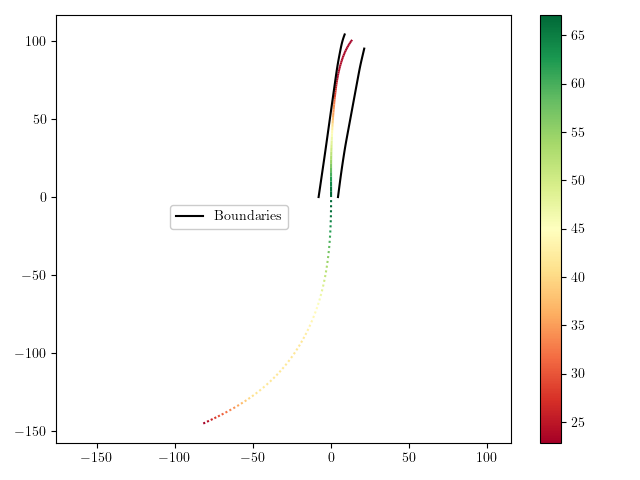

[52.54928366 53.07485696 53.61230004 54.1520194  54.67279111 55.15259725
 55.57439129 55.95959833 56.35241396 56.79229011 57.27384872 57.7411734
 58.13871419 58.42807172 58.61715466 58.72052514 58.75041586 58.73249035
 58.70104348 58.68926765 58.70591512 58.73428314 58.75731999 58.76287816
 58.75315669 58.7326457  58.70504562 58.68228139 58.6854755  58.73428055
 58.84206189 58.98848613 59.14040229 59.26863243 59.3682688  59.46377473
 59.5793651  59.73485881 59.93586922 60.18281971 60.47657648 60.81073566
 61.16825972 61.53060612 61.88141008 62.22542869 62.57819558 62.95634326
 63.36521663 63.79383469 64.2284924  64.65523806 65.06969327 65.47390806
 65.87176923 66.26001528 66.61401321 66.90365807 67.08397189 66.99351427
 66.41070486]


In [11]:
del fulldset
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)

# idx_good = plot_outliers([composite_results, mtr_results, mixnet_results, bezier_results], plots_dir, fulldset, N=25, metric_key="ade", worst=False)




# sample = fulldset[idx_good[26]]
from scipy.spatial.transform import Rotation
from matplotlib.collections import LineCollection, Collection
from matplotlib.colors import BoundaryNorm, ListedColormap, Colormap
from matplotlib.legend_handler import HandlerLineCollection
import matplotlib.cm
class HandlerColorLineCollection(HandlerLineCollection):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        x = np.linspace(0,width,self.get_numpoints(legend)+1)
        y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=artist.cmap,
                     transform=trans, linestyle=artist.get_linestyle())
        lc.set_array(x)
        lc.set_linewidth(artist.get_linewidth())
        return [lc]
def add_colored_line(points : np.ndarray, cvals : np.ndarray, ax : matplotlib.axes.Axes, cmap : str | Colormap, 
    linestyle="solid", alpha=1.0) -> tuple[LineCollection, Collection]:
    points_exp = points.reshape(-1, 1, points.shape[-1])
    segments = np.concatenate([points_exp[:-1], points_exp[1:]], axis=1)
    norm = plt.Normalize(cvals.min(), cvals.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm,linestyle=linestyle, alpha=alpha)
    
    lc.set_array(cvals)
    line = ax.add_collection(lc)
    return lc, line

sample = fulldset[idx_mtr_bad_ade[7]]
print(sample.keys())

Rmat = Rotation.from_rotvec([0.0, 0.0, 0.5*np.pi]).as_matrix()[0:2,0:2]
history_start = 0
thistory = sample["thistory"]
history = (Rmat @ sample["hist"][history_start:,[0,1]].T).T
history_vels = sample["hist_vel"][:,[0,1]]
history_speeds = np.linalg.norm(history_vels, ord=2.0, axis=1)

tfuture = sample["tfuture"]
ground_truth = (Rmat @ sample["fut"][:,[0,1]].T).T
ground_truth_vels = sample["fut_vel"][:,[0,1]]
ground_truth_speeds = np.linalg.norm(ground_truth_vels, ord=2.0, axis=1)

all_points = np.concatenate([history, ground_truth], axis=0)
all_speeds = np.concatenate([history_speeds, ground_truth_speeds], axis=0)




future_left_bd = (Rmat @ sample["future_left_bd"][:,[0,1]].T).T
future_right_bd = (Rmat @ sample["future_right_bd"][:,[0,1]].T).T
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
asdf : tuple[matplotlib.figure.Figure, matplotlib.axes.Axes] = plt.subplots(1,1)
fig : matplotlib.figure.Figure = asdf[0]
ax : matplotlib.axes.Axes = asdf[1]
norm = plt.Normalize(all_speeds.min(), all_speeds.max(), clip=True)
cmap = "RdYlGn"
scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
lc_hist, line_hist = add_colored_line(history, history_speeds[:-1], ax, cmap, linestyle="dotted")
lc_ground_truth, line_ground_truth  = add_colored_line(ground_truth, ground_truth_speeds[:-1], ax, cmap)
line_ground_truth.set_label("asdf")
lc_ground_truth.set_label("asdf")
# lc_fake, line_fake  = add_colored_line(all_points, all_speeds[:-1], ax, cmap, alpha=0.25)

# ax.plot(history[:,0], history[:,1], linestyle="--", color=history_speeds, cmap="viridis", norm=norm, alpha=0.5, label="History")
# ax.plot(ground_truth[:,0], ground_truth[:,1], linestyle="dotted", color="black", label="Ground Truth")
ax.plot(future_left_bd[:,0], future_left_bd[:,1], linestyle="solid", color="black")
boundaries = ax.plot(future_right_bd[:,0], future_right_bd[:,1], linestyle="solid", color="black")
ax.axis("equal")
ax.legend([
            #    lc_hist, 
            #    lc_ground_truth,
               boundaries[0],
           ],
           [
        #    [   "History", 
        #        "Ground Truth", 
               "Boundaries",
           ], loc=(0.25, 0.5),
          handler_map={
              lc_hist: HandlerColorLineCollection(numpoints=4),
              lc_ground_truth: HandlerColorLineCollection(numpoints=4),

            },
            framealpha=1)
fig.colorbar(scalar_mappable, ax=ax)
fig.tight_layout()
fig.savefig(os.path.join(plots_dir, "label.svg"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "label.pdf"), pad_inches=0.02)
# fig2  = plt.figure()
# plt.plot(thistory, history_speeds)
# plt.plot(tfuture, ground_truth_speeds)
plt.show()
print(history_speeds)
# plt.close(fig=fig)